In [2]:
%matplotlib inline
import re
import sys
import math
import matplotlib
import seaborn
import numpy
from matplotlib import pyplot as plt
from collections import defaultdict

from evalutils import IntervalForest, populate_index_from_bed, compact
from evalutils import subset_variants_bed, load_kevlar_vcf, load_gatk_mvf, load_triodenovo_vcf
import kevlar

seaborn.set_context({'figure.figsize': (24, 12)})
matplotlib.rcParams['axes.labelsize'] = 16
matplotlib.rcParams['xtick.labelsize'] = 14
matplotlib.rcParams['ytick.labelsize'] = 14

In [3]:
def roc(calls, index, delta=10, fmt='vcf'):
    ncorrect = 0
    num_true_calls_per_false_call = list()
    for varcall in calls:
        if fmt == 'vcf':
            valid = index.query(varcall.seqid, varcall.position, delta=delta) != set()
        elif fmt == 'mvf':
            callindex, call = varcall
            valid = index.query(call['CHROM'], call['POS'], delta=delta) != set()
        else:
            raise ValueError('unknown format "'+ fmt +'"')
        if valid:
            ncorrect += 1
            continue
        num_true_calls_per_false_call.append(ncorrect)
    if len(num_true_calls_per_false_call) == 0 or ncorrect > num_true_calls_per_false_call[-1]:
        num_true_calls_per_false_call.append(ncorrect)
    return num_true_calls_per_false_call

In [4]:
delta = 10
with kevlar.open('14153-refr-calls-denovodb-dedup.bed', 'r') as bedin:
    index = populate_index_from_bed(bedin)
kevlarcalls = list(load_kevlar_vcf('calls.likescoremin50.varfilt.scored.vcf.gz', index, delta=delta))

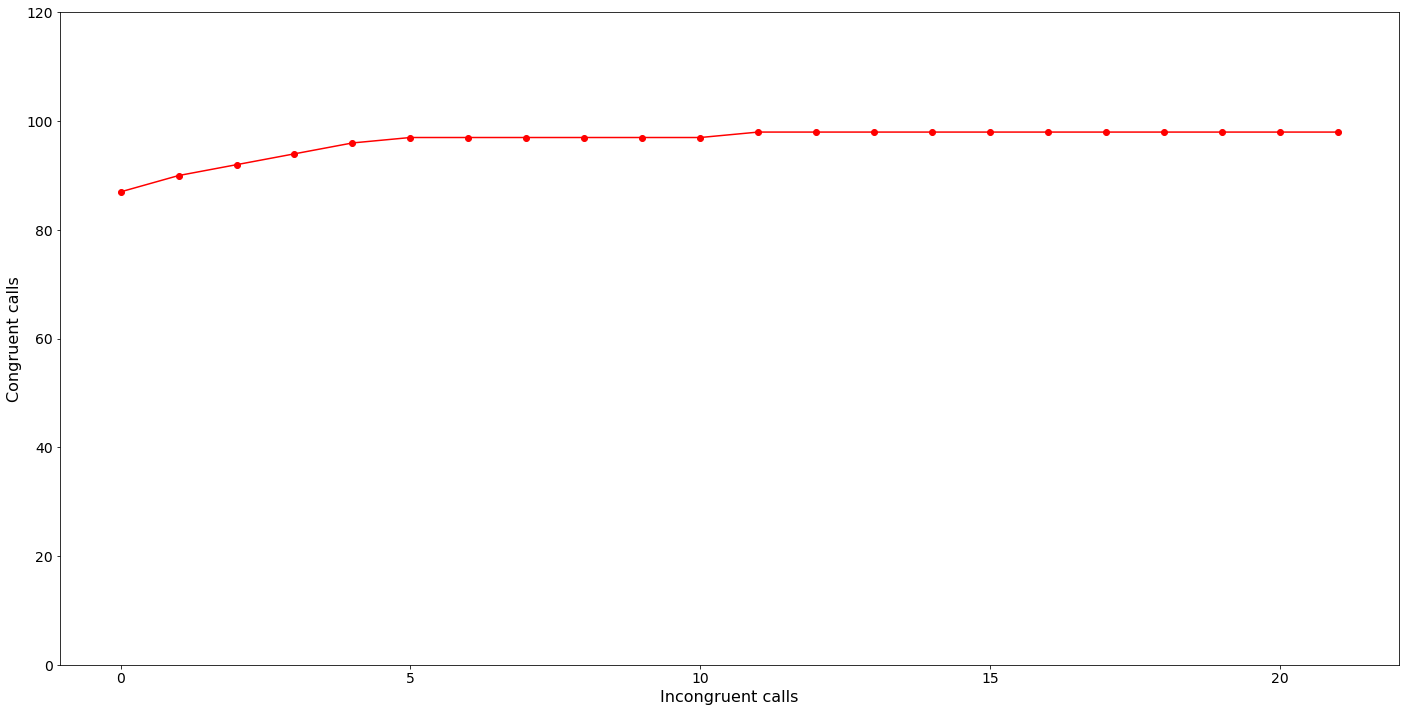

In [5]:
truecalls = roc(kevlarcalls[:120], index, delta=delta, fmt='vcf')
plt.plot(range(len(truecalls)), truecalls, color='red')
plt.plot(range(len(truecalls)), truecalls, 'o', color='red', markevery=1)
_ = plt.xlabel('Incongruent calls', fontsize=16)
_ = plt.ylabel('Congruent calls', fontsize=16)
_ = plt.ylim((0, 120))
_ = plt.savefig('kevlar-vs-denovodb.pdf', dpi=300)